In [19]:
"""
## 1. Setup & Configuration
"""

# 1.1 Imports
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
    cross_validate,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    make_scorer,
)
import warnings

warnings.filterwarnings("ignore")
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Imports réussis")

# 1.2 Configuration MLFlow - CORRIGÉE
EXPERIMENT_NAME = "home_credit_default_risk"

# IMPORTANT : Vérifier si l'expérience existe, sinon la créer
try:
    # Essayer de récupérer l'expérience existante
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

    if experiment is None:
        # L'expérience n'existe pas, on la crée
        experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
        print(f"✅ Expérience créée: {EXPERIMENT_NAME} (ID: {experiment_id})")
    else:
        # L'expérience existe déjà
        experiment_id = experiment.experiment_id
        print(f"✅ Expérience trouvée: {EXPERIMENT_NAME} (ID: {experiment_id})")

    # Définir l'expérience active
    mlflow.set_experiment(EXPERIMENT_NAME)

except Exception as e:
    print(f"⚠️ Erreur MLFlow: {e}")
    print("💡 Solution : Création manuelle de l'expérience...")
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
    mlflow.set_experiment(EXPERIMENT_NAME)
    print(f"✅ Expérience créée: {EXPERIMENT_NAME} (ID: {experiment_id})")

print(f"✅ Tracking URI: {mlflow.get_tracking_uri()}")
print(f"✅ Expérience active: {mlflow.get_experiment_by_name(EXPERIMENT_NAME).name}")

# 1.3 Charger les données preprocessed
DATA_PATH = Path("../data")
train = pd.read_csv(DATA_PATH / "train_preprocessed.csv")

print(f"✅ Données chargées: {train.shape}")

# Séparer X, y
X_train = train.drop(["TARGET", "SK_ID_CURR"], axis=1)
y_train = train["TARGET"]

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ y_train distribution: {y_train.value_counts().to_dict()}")

# 1.4 Paramètres globaux
RANDOM_STATE = 42
N_FOLDS = 5
COST_FN = 10  # Coût d'un Faux Négatif = 10x Faux Positif

print("\n" + "=" * 60)
print("🎯 CONFIGURATION TERMINÉE")
print("=" * 60)

✅ Imports réussis
✅ Expérience trouvée: home_credit_default_risk (ID: 1)
✅ Tracking URI: http://127.0.0.1:5000
✅ Expérience active: home_credit_default_risk
✅ Données chargées: (307511, 421)
✅ X_train shape: (307511, 419)
✅ y_train distribution: {0: 282686, 1: 24825}

🎯 CONFIGURATION TERMINÉE


In [12]:
"""
## 2. Score Métier Personnalisé

Le déséquilibre du coût métier :
- Faux Négatif (FN) : Mauvais client prédit bon → Crédit accordé → PERTE
- Faux Positif (FP) : Bon client prédit mauvais → Crédit refusé → Manque à gagner

Hypothèse : Coût FN = 10 × Coût FP
"""


def business_cost_score(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcule le coût métier total.

    Plus le score est BAS, meilleur est le modèle.

    Parameters:
    -----------
    y_true : array-like
        Vraies valeurs (0 ou 1)
    y_pred : array-like
        Prédictions (0 ou 1)
    cost_fn : float
        Coût d'un Faux Négatif
    cost_fp : float
        Coût d'un Faux Positif

    Returns:
    --------
    float : Coût métier total
    """
    from sklearn.metrics import confusion_matrix

    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Coût total
    total_cost = (fn * cost_fn) + (fp * cost_fp)

    # Normaliser par le nombre d'exemples
    cost_per_client = total_cost / len(y_true)

    return cost_per_client


def business_score_from_proba(y_true, y_proba, threshold=0.5, cost_fn=10, cost_fp=1):
    """
    Calcule le score métier à partir de probabilités et d'un seuil.
    """
    y_pred = (y_proba >= threshold).astype(int)
    return business_cost_score(y_true, y_pred, cost_fn, cost_fp)


# Test du score
print("\n📊 Test du Score Métier:")
print("=" * 60)

# Scénario 1 : Modèle parfait
y_true_test = np.array([0, 0, 1, 1])
y_pred_perfect = np.array([0, 0, 1, 1])
cost_perfect = business_cost_score(y_true_test, y_pred_perfect, COST_FN, 1)
print(f"Modèle parfait : Coût = {cost_perfect:.4f}")

# Scénario 2 : 1 Faux Négatif
y_pred_fn = np.array([0, 0, 0, 1])  # Manque 1 défaut
cost_fn = business_cost_score(y_true_test, y_pred_fn, COST_FN, 1)
print(f"1 Faux Négatif : Coût = {cost_fn:.4f} (= {COST_FN}/4 = {COST_FN / 4:.2f})")

# Scénario 3 : 1 Faux Positif
y_pred_fp = np.array([1, 0, 1, 1])  # Rejette 1 bon client
cost_fp = business_cost_score(y_true_test, y_pred_fp, COST_FN, 1)
print(f"1 Faux Positif : Coût = {cost_fp:.4f} (= 1/4 = {1 / 4:.2f})")

print(f"\n💡 Un FN coûte {cost_fn / cost_fp:.0f}x plus qu'un FP")


📊 Test du Score Métier:
Modèle parfait : Coût = 0.0000
1 Faux Négatif : Coût = 2.5000 (= 10/4 = 2.50)
1 Faux Positif : Coût = 0.2500 (= 1/4 = 0.25)

💡 Un FN coûte 10x plus qu'un FP


In [20]:
def train_and_log_model(model, model_name, X_train, y_train, params=None):
    with mlflow.start_run(run_name=model_name):
        # --- 1. Paramètres & Métadonnées ---
        if params:
            mlflow.log_params(params)
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("train_shape", str(X_train.shape))
        mlflow.log_param(
            "target_dist", str(y_train.value_counts(normalize=True).to_dict())
        )

        # --- 2. Cross-Validation (Technique + Métier) ---
        scoring = {
            "auc": "roc_auc",
            "business": make_scorer(
                business_cost_score, cost_fn=COST_FN, cost_fp=1, greater_is_better=False
            ),
        }

        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=StratifiedKFold(
                n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE
            ),
            scoring=scoring,
            return_train_score=True,
            n_jobs=-1,
        )

        # --- 3. Entraînement final & Prédictions ---
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_train)[:, 1]

        # On utilise le seuil par défaut 0.5 pour la baseline
        y_pred_05 = (y_proba >= 0.5).astype(int)

        # --- 4. Calcul des métriques ---
        train_auc = roc_auc_score(y_train, y_proba)
        cv_auc_mean = cv_results["test_auc"].mean()
        train_cost = business_cost_score(y_train, y_pred_05, COST_FN, 1)

        # Matrice de confusion (pour extraire TN, FP, FN, TP)
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred_05).ravel()

        # --- 5. LOGS MLFLOW  ---
        # CV Metrics
        mlflow.log_metric("cv_auc_mean", cv_auc_mean)
        mlflow.log_metric("cv_auc_std", cv_results["test_auc"].std())
        mlflow.log_metric("cv_business_cost_mean", -cv_results["test_business"].mean())

        # Train Metrics
        mlflow.log_metric("train_auc", train_auc)
        mlflow.log_metric("train_business_cost", train_cost)

        # Overfitting Gaps
        mlflow.log_metric("auc_gap", train_auc - cv_auc_mean)

        # Confusion Matrix Metrics
        mlflow.log_metric("train_tn", int(tn))
        mlflow.log_metric("train_fp", int(fp))
        mlflow.log_metric("train_fn", int(fn))
        mlflow.log_metric("train_tp", int(tp))

        # --- 6. Artefacts (Plots & Modèle) ---
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(
            confusion_matrix(y_train, y_pred_05), annot=True, fmt="d", cmap="Blues"
        )
        mlflow.log_figure(fig, "confusion_matrix_default.png")
        plt.close()

        mlflow.sklearn.log_model(model, "model")

        print(
            f"✅ {model_name} | CV AUC: {cv_auc_mean:.4f} | Gap: {train_auc - cv_auc_mean:.4f}"
        )

        return -cv_results["test_business"].mean()

In [21]:
# Définition des modèles à tester
models_to_test = [
    {
        "name": "Logistic_Regression_Baseline",
        "model": LogisticRegression(
            max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced"
        ),
        "params": {"max_iter": 1000, "class_weight": "balanced"},
    },
    {
        "name": "RandomForest_Baseline",
        "model": RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=RANDOM_STATE,
            class_weight="balanced",
            n_jobs=-1,
        ),
        "params": {"n_estimators": 100, "max_depth": 10},
    },
    {
        "name": "LightGBM_Baseline",
        "model": lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=7,
            random_state=RANDOM_STATE,
            class_weight="balanced",
        ),
        "params": {"n_estimators": 100, "learning_rate": 0.1},
    },
]

# Exécution de la boucle
results_list = []

print("\n" + "=" * 60)
print("🚀 DÉMARRAGE DES ENTRAÎNEMENTS BASELINES")
print("=" * 60)

for m in models_to_test:
    score = train_and_log_model(
        m["model"], m["name"], X_train, y_train, params=m["params"]
    )
    results_list.append({"Model": m["name"], "CV Business Cost": score})

# 3. Comparaison finale
print("\n" + "=" * 60)
print("📊 RÉSULTATS FINAUX")
print("=" * 60)
baseline_results = pd.DataFrame(results_list).sort_values("CV Business Cost")
print(baseline_results.to_string(index=False))

best_baseline = baseline_results.iloc[0]["Model"]
print(f"\n💡 Le meilleur modèle est : {best_baseline}")


🚀 DÉMARRAGE DES ENTRAÎNEMENTS BASELINES


2026/01/05 19:02:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 19:02:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✅ Logistic_Regression_Baseline | CV AUC: 0.7715 | Gap: 0.0048
🏃 View run Logistic_Regression_Baseline at: http://127.0.0.1:5000/#/experiments/1/runs/43ee3412e9eb47628e91743bf15dcb29
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2026/01/05 19:04:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 19:04:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✅ RandomForest_Baseline | CV AUC: 0.7563 | Gap: 0.0679
🏃 View run RandomForest_Baseline at: http://127.0.0.1:5000/#/experiments/1/runs/974820c0502e427a9df8bde0c65f3f72
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.826112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46835
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 403
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.518729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

2026/01/05 19:04:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 19:04:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✅ LightGBM_Baseline | CV AUC: 0.7805 | Gap: 0.0358
🏃 View run LightGBM_Baseline at: http://127.0.0.1:5000/#/experiments/1/runs/78ec0355b75e41909ffb56c88b0d4808
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

📊 RÉSULTATS FINAUX
                       Model  CV Business Cost
           LightGBM_Baseline          0.496454
Logistic_Regression_Baseline          0.509605
       RandomForest_Baseline          0.534075

💡 Le meilleur modèle est : LightGBM_Baseline


In [26]:
"""
## 4. Hyperparameter Tuning avec GridSearchCV (Harmonisé)

On optimise le meilleur modèle baseline avec GridSearchCV.
On utilise le multi-scoring pour logger l'AUC et le Score Métier en même temps.
"""

best_baseline_name = "LightGBM"

print(f"\n🔍 Hyperparameter Tuning sur {best_baseline_name}")
print("=" * 60)

# 1. Définition des scorers (AUC + Métier)
scoring = {
    "AUC": "roc_auc",
    "Business_Score": make_scorer(
        business_cost_score, greater_is_better=False, cost_fn=COST_FN, cost_fp=1
    ),
}

# 2. Grille de paramètres
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [5, 7, 10],
    "num_leaves": [31, 50, 70],
    "force_row_wise": [True],
    "verbosity": [-1],
}

lgbm_grid = lgb.LGBMClassifier(
    random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1
)

# 3. GridSearchCV
grid_search = GridSearchCV(
    lgbm_grid,
    param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring=scoring,
    refit="Business_Score",  # Crucial: On choisit le meilleur modèle selon le coût métier
    return_train_score=True,  # Pour calculer les gaps d'overfitting
    n_jobs=-1,
    verbose=2,
)

print("⏳ GridSearch en cours...")
grid_search.fit(X_train, y_train)

# --- 4. LOG HARMONISÉ DANS MLFLOW ---

with mlflow.start_run(run_name=f"{best_baseline_name}_Tuned_Complete"):
    # Index du meilleur run
    idx = grid_search.best_index_
    best_model = grid_search.best_estimator_

    # A. Paramètres
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("model_type", f"{best_baseline_name}_Tuned")
    mlflow.log_param("n_features", X_train.shape[1])

    # B. Métriques de Cross-Validation (Moyennes et Écarts-types)
    cv_auc_mean = grid_search.cv_results_["mean_test_AUC"][idx]
    cv_cost_mean = -grid_search.cv_results_["mean_test_Business_Score"][idx]

    mlflow.log_metric("cv_auc_mean", cv_auc_mean)
    mlflow.log_metric("cv_auc_std", grid_search.cv_results_["std_test_AUC"][idx])
    mlflow.log_metric("cv_business_cost_mean", cv_cost_mean)
    mlflow.log_metric(
        "cv_business_cost_std", grid_search.cv_results_["std_test_Business_Score"][idx]
    )

    # C. Métriques sur le Train (pour détection Overfitting)
    y_proba = best_model.predict_proba(X_train)[:, 1]
    y_pred_05 = (y_proba >= 0.5).astype(int)  # Seuil baseline

    train_auc = roc_auc_score(y_train, y_proba)
    train_cost = business_cost_score(y_train, y_pred_05, COST_FN, 1)

    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("train_business_cost", train_cost)

    # D. Gaps & Confusion Matrix
    mlflow.log_metric("auc_gap", train_auc - cv_auc_mean)

    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_05).ravel()
    mlflow.log_metric("train_fn", int(fn))
    mlflow.log_metric("train_fp", int(fp))

    # E. Artefacts
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_train, y_pred_05), annot=True, fmt="d", cmap="Blues")
    ax.set_title(f"Confusion Matrix - {best_baseline_name} Tuned (Seuil 0.5)")
    mlflow.log_figure(fig, "confusion_matrix_tuned.png")
    plt.close()

    # F. Modèle
    mlflow.sklearn.log_model(best_model, "model")

    print(f"\n✅ Tuning terminé et loggué de façon exhaustive.")
    print(f"Meilleurs paramètres: {grid_search.best_params_}")
    print(f"Meilleur CV AUC: {cv_auc_mean:.4f} | CV Business Cost: {cv_cost_mean:.4f}")


🔍 Hyperparameter Tuning sur LightGBM
⏳ GridSearch en cours...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END force_row_wise=True, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, verbosity=-1; total time=  41.9s
[CV] END force_row_wise=True, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=50, verbosity=-1; total time=  42.4s
[CV] END force_row_wise=True, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=70, verbosity=-1; total time=  43.1s
[CV] END force_row_wise=True, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, verbosity=-1; total time=  43.5s
[CV] END force_row_wise=True, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=50, verbosity=-1; total time=  44.1s
[CV] END force_row_wise=True, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, verbosity=-1; total time=  44.1s
[CV] END force_row_wise=True, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=70, verbo

2026/01/05 19:56:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 19:56:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.



✅ Tuning terminé et loggué de façon exhaustive.
Meilleurs paramètres: {'force_row_wise': True, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 31, 'verbosity': -1}
Meilleur CV AUC: 0.7804 | CV Business Cost: 0.4964
🏃 View run LightGBM_Tuned_Complete at: http://127.0.0.1:5000/#/experiments/1/runs/4a33c67963754457888e49328a8c5e35
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


on relance pas le gridsearch pour rien trop long donc bloc de code pour mettre a jour le run


In [ ]:
# # 1. On récupère le meilleur estimateur issu du GridSearch
# final_model = grid_search.best_estimator_

# # 2. Recalcul des métriques de CV (pour avoir AUC + Business Cost + Ecarts-types)
# print("⏳ Calcul des métriques exhaustives pour le run final...")
# scoring_harmonie = {
#     "auc": "roc_auc",
#     "business": make_scorer(
#         business_cost_score, cost_fn=COST_FN, cost_fp=1, greater_is_better=False
#     ),
# }
# cv_results = cross_validate(
#     final_model,
#     X_train,
#     y_train,
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
#     scoring=scoring_harmonie,
#     return_train_score=True,
#     n_jobs=-1,
# )

# # 3. Création du Run Harmonisé
# with mlflow.start_run(run_name=f"{best_baseline}_Tuned_Complete"):
#     # --- A. PARAMÈTRES & MÉTA-DONNÉES ---
#     mlflow.log_params(grid_search.best_params_)
#     mlflow.log_param("model_type", f"{best_baseline}_Tuned")
#     mlflow.log_param("n_features", X_train.shape[1])
#     mlflow.log_param("train_shape", str(X_train.shape))
#     mlflow.log_param("target_distribution", str(y_train.value_counts().to_dict()))

#     # --- B. CV METRICS (Validation) ---
#     cv_auc_mean = cv_results["test_auc"].mean()
#     cv_cost_mean = -cv_results[
#         "test_business"
#     ].mean()  # On repasse en positif pour le coût

#     mlflow.log_metric("cv_auc_mean", cv_auc_mean)
#     mlflow.log_metric("cv_auc_std", cv_results["test_auc"].std())
#     mlflow.log_metric("cv_business_cost_mean", cv_cost_mean)
#     mlflow.log_metric("cv_business_cost_std", cv_results["test_business"].std())

#     # --- C. TRAIN METRICS (Sur tout le dataset) ---
#     y_proba = final_model.predict_proba(X_train)[:, 1]
#     y_pred_05 = (y_proba >= 0.5).astype(int)

#     train_auc = roc_auc_score(y_train, y_proba)
#     train_cost = business_cost_score(y_train, y_pred_05, COST_FN, 1)

#     mlflow.log_metric("train_auc", train_auc)
#     mlflow.log_metric("train_business_cost", train_cost)

#     # --- D. CONFUSION MATRIX METRICS ---
#     tn, fp, fn, tp = confusion_matrix(y_train, y_pred_05).ravel()
#     mlflow.log_metric("train_tn", int(tn))
#     mlflow.log_metric("train_fp", int(fp))
#     mlflow.log_metric("train_fn", int(fn))
#     mlflow.log_metric("train_tp", int(tp))

#     # --- E. GAPS (Overfitting Detection) ---
#     mlflow.log_metric("auc_gap", train_auc - cv_auc_mean)
#     mlflow.log_metric("cost_gap", train_cost - cv_cost_mean)

#     # --- F. ARTEFACTS & MODÈLE ---
#     fig, ax = plt.subplots(figsize=(6, 5))
#     sns.heatmap(confusion_matrix(y_train, y_pred_05), annot=True, fmt="d", cmap="Blues")
#     ax.set_title(f"Confusion Matrix - {best_baseline} Tuned (Threshold 0.5)")
#     mlflow.log_figure(fig, "confusion_matrix_final.png")
#     plt.close()

#     mlflow.sklearn.log_model(final_model, "model")

#     print(
#         f"✅ Run '{best_baseline}_Tuned_Complete' créé avec {14} métriques et tous les paramètres."
#     )

⏳ Calcul des métriques exhaustives pour le run final...
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46864
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 401
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [In

2026/01/05 19:11:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 19:11:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✅ Run 'LightGBM_Baseline_Tuned_Complete' créé avec 14 métriques et tous les paramètres.
🏃 View run LightGBM_Baseline_Tuned_Complete at: http://127.0.0.1:5000/#/experiments/1/runs/b9143f285b744f25936f58e0377a0719
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2026/01/05 20:22:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/05 20:23:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'Credit_Scoring_Model_LGBM' already exists. Creating a new version of this model...
2026/01/05 20:23:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Scoring_Model_LGBM, version 3


✅ Modèle Final loggué et enregistré !
Score CV métier: 0.4964 (± 0.0027)
Gain métier sur train (seuil 0.5 -> 0.515): 0.3%
🏃 View run LightGBM_Baseline_FINAL_MODEL at: http://127.0.0.1:5000/#/experiments/1/runs/80eb9e710de04bbc851d2fec814bc2b7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Created version '3' of model 'Credit_Scoring_Model_LGBM'.


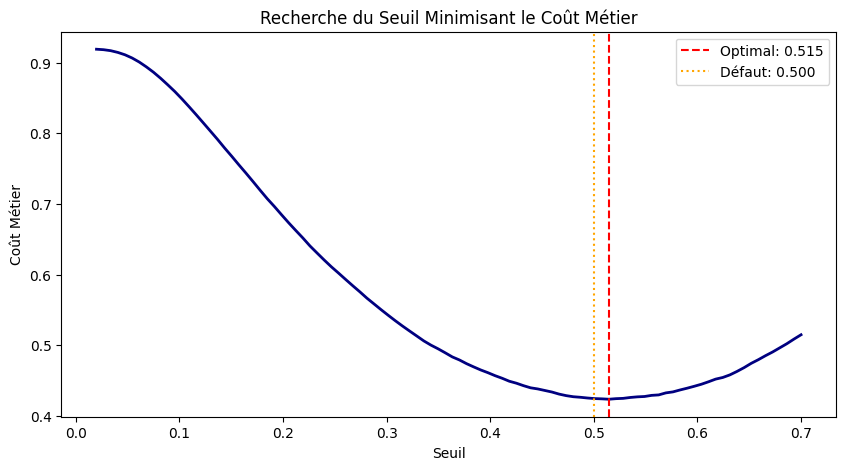

In [ ]:
def find_optimal_threshold(y_true, y_proba, cost_fn=10, cost_fp=1):
    """
    Trouve le seuil optimal.
    Note: On élargit l'intervalle car avec FN=10, le seuil est souvent bas.
    """
    thresholds = np.linspace(0.02, 0.7, 100)  # Plus de précision sur les seuils bas
    costs = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        cost = business_cost_score(y_true, y_pred, cost_fn, cost_fp)
        costs.append(cost)

    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    optimal_cost = costs[optimal_idx]

    # Figure d'optimisation
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(thresholds, costs, color="navy", lw=2)
    ax.axvline(
        optimal_threshold,
        color="red",
        linestyle="--",
        label=f"Optimal: {optimal_threshold:.3f}",
    )
    ax.axvline(0.5, color="orange", linestyle=":", label="Défaut: 0.500")
    ax.set_title("Recherche du Seuil Minimisant le Coût Métier")
    ax.set_xlabel("Seuil")
    ax.set_ylabel("Coût Métier")
    ax.legend()

    return optimal_threshold, optimal_cost, fig


# --- Exécution ---

y_train_proba = best_model.predict_proba(X_train)[:, 1]
optimal_thresh, optimal_cost, fig_thresh = find_optimal_threshold(
    y_train, y_train_proba, COST_FN, 1
)

# Calcul des prédictions finales
y_pred_opt = (y_train_proba >= optimal_thresh).astype(int)
y_pred_def = (y_train_proba >= 0.5).astype(int)

# --- LOG FINAL HARMONISÉ ---

with mlflow.start_run(run_name=f"{best_baseline}_FINAL_MODEL"):
    # 1. Hyperparamètres et Seuil
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("optimal_threshold", round(optimal_thresh, 3))
    mlflow.log_param("model_type", f"{best_baseline}_Tuned_Final")

    # 2. Métriques de Cross-Validation (Harmonisation avec les Baselines)
    # On récupère les résultats du GridSearch pour le meilleur index
    best_idx = grid_search.best_index_

    cv_auc = grid_search.cv_results_["mean_test_AUC"][best_idx]
    cv_cost = -grid_search.cv_results_["mean_test_Business_Score"][
        best_idx
    ]  # On repasse en positif
    cv_cost_std = grid_search.cv_results_["std_test_Business_Score"][best_idx]

    mlflow.log_metric("cv_auc_mean", cv_auc)
    mlflow.log_metric("cv_business_cost_mean", cv_cost)
    mlflow.log_metric("cv_business_cost_std", cv_cost_std)

    # 3. Métriques de performance sur le Train (Technique)
    train_auc = roc_auc_score(y_train, y_train_proba)
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("auc_gap", train_auc - cv_auc)

    # 4. Impact Métier du Seuil (La valeur ajoutée de cette étape)
    cost_def = business_cost_score(y_train, y_pred_def, COST_FN, 1)
    mlflow.log_metric("train_business_cost_at_05", cost_def)
    mlflow.log_metric("train_business_cost_optimal", optimal_cost)

    improvement = ((cost_def - optimal_cost) / cost_def) * 100
    mlflow.log_metric("threshold_improvement_percent", improvement)

    # 5. Confusion Matrix au seuil OPTIMAL
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_opt).ravel()
    mlflow.log_metric("final_train_fn", int(fn))
    mlflow.log_metric("final_train_fp", int(fp))
    mlflow.log_metric("final_train_tp", int(tp))
    mlflow.log_metric("final_train_tn", int(tn))

    # 6. Artefacts
    mlflow.log_figure(fig_thresh, "threshold_optimization_curve.png")

    fig_cm, ax = plt.subplots()
    sns.heatmap(
        confusion_matrix(y_train, y_pred_opt), annot=True, fmt="d", cmap="Greens"
    )
    ax.set_title(f"Matrice de Confusion au Seuil Optimal ({optimal_thresh:.3f})")
    mlflow.log_figure(fig_cm, "final_confusion_matrix.png")
    plt.close()

    # 7. Model Registry
    mlflow.sklearn.log_model(
        best_model, "model", registered_model_name="Credit_Scoring_Model_LGBM"
    )

    print(f"✅ Modèle Final loggué et enregistré !")
    print(f"Score CV métier: {cv_cost:.4f} (± {cv_cost_std:.4f})")
    print(
        f"Gain métier sur train (seuil 0.5 -> {optimal_thresh:.3f}): {improvement:.1f}%"
    )


In [40]:
"""
## 6. Comparaison Finale et Sélection du Meilleur Modèle
"""

print("\n" + "=" * 60)
print("📊 COMPARAISON FINALE DES MODÈLES")
print("=" * 60)

# Récupérer tous les runs de l'experiment
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Trier par business_cost
runs_sorted = runs.sort_values("metrics.cv_business_cost_mean", ascending=True)

# Afficher le top 10 des modèles
print("\nTop 10 Modèles (triés par coût métier):")
columns_to_show = [
    "tags.mlflow.runName",
    "metrics.cv_business_cost_mean",  # Correct
    "metrics.train_auc",  # Correct
    "metrics.cv_auc_mean",  # Ajout du préfixe 'metrics.' ici !
    "metrics.auc_gap",  # Si tu l'as loggué, c'est très utile à voir
]

# On ne garde que les colonnes qui existent réellement pour éviter un nouveau crash
existing_cols = [c for c in columns_to_show if c in runs_sorted.columns]

print(runs_sorted[existing_cols].head(10).to_string(index=False))
# Sélectionner le meilleur
best_run_id = runs_sorted.iloc[0]["run_id"]
best_run_name = runs_sorted.iloc[0]["tags.mlflow.runName"]

print(f"\n✅ Meilleur modèle: {best_run_name}")
print(f"✅ Run ID: {best_run_id}")


📊 COMPARAISON FINALE DES MODÈLES

Top 10 Modèles (triés par coût métier):
          tags.mlflow.runName  metrics.cv_business_cost_mean  metrics.train_auc  metrics.cv_auc_mean  metrics.auc_gap
LightGBM_Baseline_FINAL_MODEL                       0.496408           0.834454             0.780372         0.054082
      LightGBM_Tuned_Complete                       0.496408           0.834454             0.780372         0.054082
            LightGBM_Baseline                       0.496454           0.816340             0.780524         0.035816
 Logistic_Regression_Baseline                       0.509605           0.776312             0.771517         0.004796
        RandomForest_Baseline                       0.534075           0.824200             0.756269         0.067931

✅ Meilleur modèle: LightGBM_Baseline_FINAL_MODEL
✅ Run ID: f9d4aadcd9ac4954bb0d30f1041a2e67


In [ ]:
"""
## 8. Model Serving - Test du Modèle en Production
"""
# S'assurer que le nom correspond à ce qui a été enregistré plus haut
model_name = "Credit_Scoring_Model_LGBM"

# Charger la dernière version (au lieu de "Production" qui est peut-être vide)
model_uri = f"models:/{model_name}/latest"
print(f"Chargement du modèle depuis : {model_uri}")

model_production = mlflow.sklearn.load_model(
    model_uri
)  # Utilise sklearn.load_model pour garder predict_proba

# 1. Aligner X_test sur les features du modèle de façon robuste
features_cols = model_production.feature_name_

# reindex ajoute les colonnes manquantes (fill_value=0) et retire les colonnes en trop
X_test_aligned = X_test.reindex(columns=features_cols, fill_value=0)

print(
    f"✅ Alignement terminé : {X_test.shape[1]} -> {X_test_aligned.shape[1]} colonnes"
)

# 2. Test sur l'échantillon
print(f"\n🧪 Test du Modèle en Production :")
print("=" * 60)

X_sample = X_test_aligned.head(5)
predictions_proba = model_production.predict_proba(X_sample)[:, 1]
predictions = (predictions_proba >= optimal_thresh).astype(int)

# 3. Affichage
result_df = pd.DataFrame(
    {
        "SK_ID_CURR": test_ids.head(5).values,
        "Probability": predictions_proba,
        "Prediction": predictions,
    }
)
print(result_df.to_string(index=False))

# 4. Génération du fichier final
print("\n📤 Génération des prédictions finales pour Kaggle...")
final_proba = model_production.predict_proba(X_test_aligned)[:, 1]

submission = pd.DataFrame(
    {
        "SK_ID_CURR": test_ids,
        "TARGET": final_proba,  # On envoie la proba pour maximiser l'AUC sur Kaggle
    }
)

submission.to_csv("../data/submission.csv", index=False)
print("✅ Fichier de soumission créé : ../data/submission.csv")

Chargement du modèle depuis : models:/Credit_Scoring_Model_LGBM/latest


✅ Alignement terminé : 420 -> 419 colonnes

🧪 Test du Modèle en Production :
 SK_ID_CURR  Probability  Prediction
     100001     0.242050           0
     100005     0.635779           1
     100013     0.248509           0
     100028     0.180654           0
     100038     0.518640           1

📤 Génération des prédictions finales pour Kaggle...
✅ Fichier de soumission créé : ../data/submission.csv


In [47]:
"""
## 9. Documentation et Export
"""

# Sauvegarder le seuil optimal et autres métadonnées
metadata = {
    "best_model_name": best_run_name,
    "best_model_run_id": best_run_id,
    "optimal_threshold": optimal_thresh,
    "cost_fn": COST_FN,
    "cost_fp": 1,
    "business_cost_optimal": cost_optimal,
    "n_features": X_train.shape[1],
    "n_train_samples": X_train.shape[0],
    "class_distribution": y_train.value_counts().to_dict(),
}

import json

with open("../models/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("\n✅ Métadonnées sauvegardées: model_metadata.json")

print("\n" + "=" * 60)
print("🎉 MODELING TERMINÉ !")
print("=" * 60)
print(f"""
RÉSUMÉ:
- Meilleur modèle: {best_run_name}
- Coût métier: {cost_optimal:.4f}
- Seuil optimal: {optimal_thresh:.3f}
- Modèle en production: {model_name} v{model_version.version}
- Fichier soumission: submission.csv

PROCHAINES ÉTAPES:
1. Lancer l'UI MLFlow: mlflow ui
2. Comparer les runs et visualisations
3. Soumettre à Kaggle
4. Documenter les résultats
""")


✅ Métadonnées sauvegardées: model_metadata.json

🎉 MODELING TERMINÉ !


NameError: name 'model_version' is not defined